In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval

from seisLM.model import supervised_models

# from seisLM.utils.project_path import gitdir
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from seisLM.utils import project_path
from seisLM.model import pretrained_models

from torchinfo import summary
from seisLM.data_pipeline import dataloaders

In [2]:
# model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-10-22h-22m-38s/checkpoints/epoch=1-step=279530.ckpt'
model_name_or_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/42__2024-06-10-22h-22m-38s/checkpoints/epoch=1-step=279530.ckpt'

pretrained_model = pretrained_models.LitMultiDimWav2Vec2.load_from_checkpoint(
    model_name_or_path
)
# make sure that the gata generator contains labeled data
pretrained_model.get_train_augmentations = supervised_models.PhaseNetLit().get_augmentations
pretrained_model.get_val_augmentations = supervised_models.PhaseNetLit().get_augmentations

pretrained_model.eval();

train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
    model=pretrained_model,
    data_names='ETHZ',
    batch_size=1,
    num_workers=2,
)
summary(pretrained_model.model, input_size=(1, 3, 3001) )


2024-06-12 00:45:38,680 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2024-06-12 00:45:39,393 | seisbench | WARNING | Skipping preload, as cache is disabled.
2024-06-12 00:45:39,394 | seisbench | WARNING | Skipping preload, as cache is disabled.


Layer (type:depth-idx)                                            Output Shape              Param #
MultiDimWav2Vec2ForPreTraining                                    --                        --
├─MultiDimWav2Vec2Model: 1-1                                      [1, 2999, 256]            240
│    └─Wav2Vec2FeatureEncoder: 2-1                                [1, 256, 2999]            --
│    │    └─ModuleList: 3-1                                       --                        3,072
│    └─Wav2Vec2FeatureProjection: 2-2                             [1, 2999, 240]            --
│    │    └─LayerNorm: 3-2                                        [1, 2999, 256]            512
│    │    └─Linear: 3-3                                           [1, 2999, 240]            61,680
│    │    └─Dropout: 3-4                                          [1, 2999, 240]            --
│    └─Wav2Vec2EncoderStableLayerNorm: 2-3                        [1, 2999, 240]            --
│    │    └─Wav2Vec2PositionalConvEm

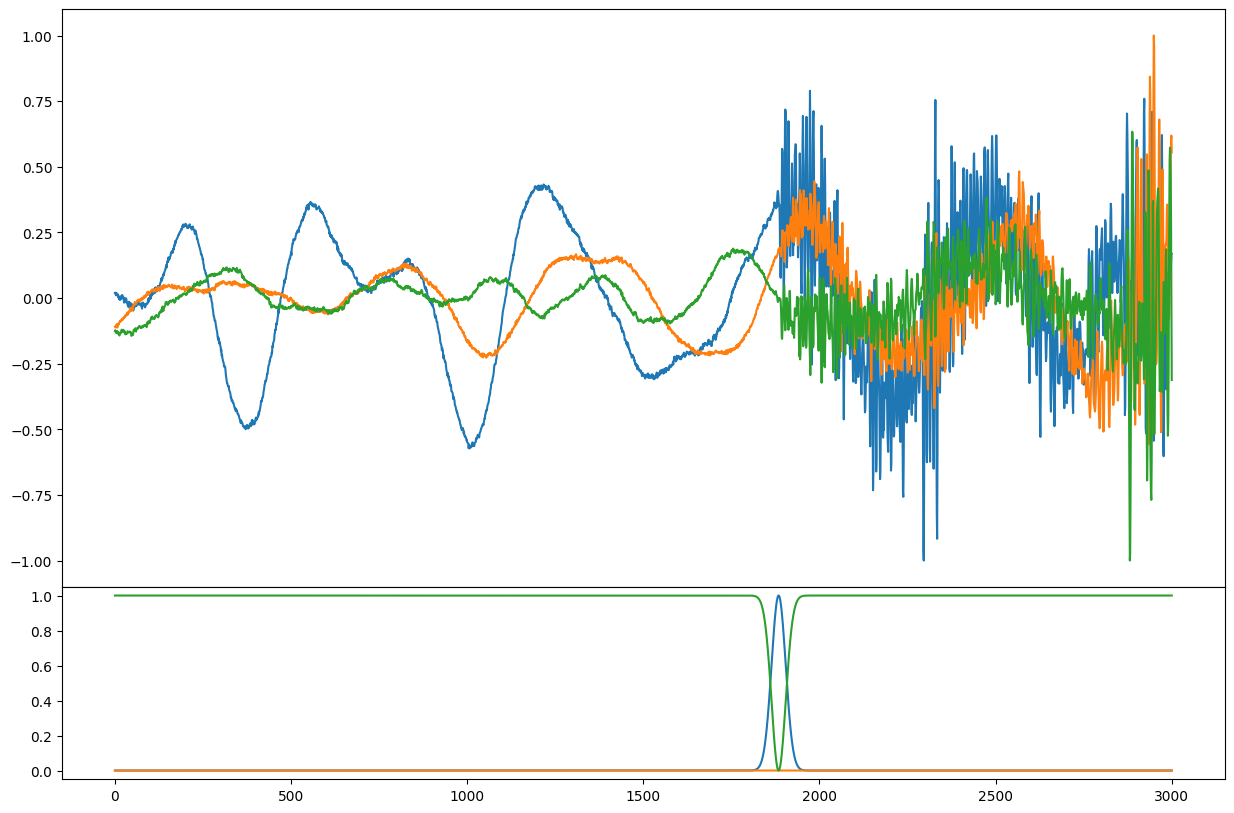

In [3]:
batch = next(iter(train_loader))

sample_x = batch['X'][0]
sample_y = batch['y'][0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample_x.T)
axs[1].plot(sample_y.T)



In [4]:
with torch.no_grad():
  out = pretrained_model.model(batch['X'].cuda())
  features = out['projected_states']
  
single_sample_feature = features.detach().cpu().numpy()[0]
  


In [20]:
features.detach().cpu().numpy().shape

(1, 2999, 256)

In [23]:
from sksfa import SFA
sfa = SFA(n_components=2)
output_features = sfa.fit_transform(features.detach().cpu().numpy()[0])



In [27]:
features

tensor([[[-7.7112e-01, -5.8607e-01,  5.9666e-01,  ..., -9.8514e-02,
           2.7161e-01, -7.9309e-04],
         [-6.8504e-01, -7.4877e-01,  8.6635e-01,  ...,  5.5267e-02,
           6.1415e-01, -3.8752e-01],
         [-4.8611e-01, -8.9561e-01,  7.2472e-01,  ...,  9.5554e-02,
           8.1632e-01, -5.2059e-01],
         ...,
         [ 4.4882e-01, -3.2673e-01,  5.3551e-01,  ...,  5.4012e-01,
          -8.0161e-01,  8.1588e-02],
         [ 4.2466e-01, -1.2803e-01,  5.1901e-01,  ...,  9.6380e-01,
          -1.0011e+00,  7.3676e-02],
         [ 3.1108e-01, -1.5594e-01,  2.9904e-01,  ...,  1.2736e+00,
          -1.4691e+00,  2.9014e-01]]], device='cuda:0')

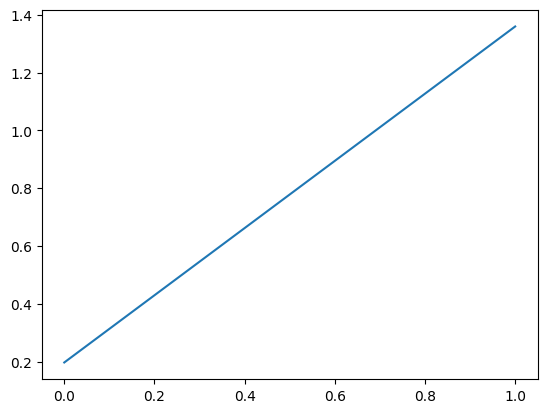

In [26]:
plt.plot(output_features[1])

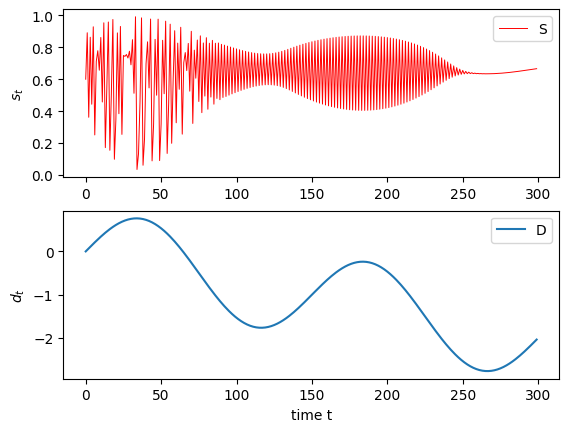

In [6]:
import numpy as np
import matplotlib.pyplot as plt

series_length = 300
S = np.zeros((series_length, 1), 'd')
D = np.zeros((series_length, 1), 'd')

S[0] = 0.6
for t in range(1, series_length):
    D[t] = np.sin(np.pi/75. * t) - t/150.
    S[t] = (3.7+0.35*D[t]) * S[t-1] * (1 - S[t-1])

plt.subplot(211)
plt.plot(np.arange(series_length), S, 'r', linewidth=0.7, label="S")
plt.legend(loc='upper right')
plt.ylabel('$s_t$')
plt.subplot(212)
plt.plot(np.arange(series_length), D,  label="D")
plt.legend(loc='upper right')
plt.xlabel('time t')
plt.ylabel('$d_t$')
plt.show()

In [9]:
# import mdp

# timeframes = mdp.nodes.TimeFramesNode(4)
# timeframed_S = timeframes.execute(S)

# cubic_expand = mdp.nodes.PolynomialExpansionNode(3)
# cubic_expanded_S = cubic_expand(timeframed_S)


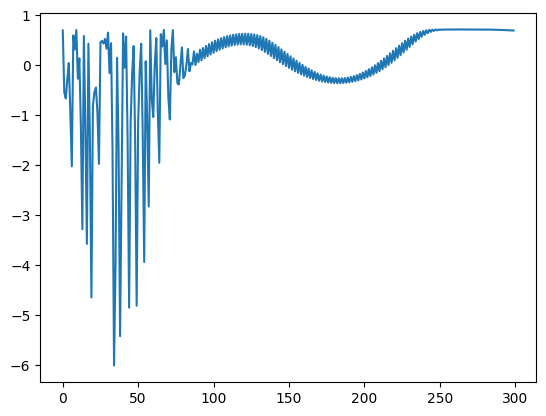

In [14]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeatures

# quadratic_sfa = Pipeline([("Expansion", PolynomialFeatures(degree=2)),
#                                ("SFA", SFA(n_components=1)) ])
# output_features = quadratic_sfa.fit_transform(S)
# plt.plot(output_features)


In [ ]:
S.shape

(300, 1)